# Deep Learning y segmentación de imágenes en la medicina


Los métodos de deep learning, principalmente las Redes Neuronales Convolucionales (CNN), han sido utilizados en el procesamiento de imágenes en tres principales areas:

### Clasificación de imágenes 
El bloque fundamental de la Visión por Computadora, lleva a cabo la tarea de clasificar una imágen de acuerdo al principal objeto de en ésta. 


![image classification](Notebook_Imgs/image_classification.gif "Classificación de Imágenes")


### Detección de objetos
Estos métodos localizán exactamente donde se encuentran los objetos presentes en una imagen y los clasifica.  


![object detection](Notebook_Imgs/object_detection.gif "Detección de objetos")


### Segmentación semántica
Se clasifica cada pixel con su clase correspodiente. A la salida de estos métodos se obtiene una imágen de alta resolución en la cual cada pixel esta marcado como correspondiente a una clase.


![segmentación](Notebook_Imgs/image_segmentation.gif "Segmentación semántica")


El principal reto de la segmentación es la reconstrucción de la imágen despues de haber realizado la extracción de características y reducido el tamaño de la imágen mediante las capas de convolución y pooling.


![arquitectura segmentación](Notebook_Imgs/segmentation_architecture.png "Arquitectura de segmentación")

## Tipos de segmentación

Las CNNs han sido utilizadas para la segmentación de imágenes utilizando diferentes aproximaciones.

### Segmentación mediante parches

Se entrena un modelo para que sea capaz de clasificar pequeñas ventanas de la imagen de acuerdo a una clase. El pixel central de esta ventana se le asigna la clase predicha por el modelo y esto se realiza para todos los pixeles. 


![Segmentación por parches](Notebook_Imgs/patch_cnn.jpg "Segmentación por parches")

__Ventajas:__ Se incrementa el número de imágenes de entramiento, ya que el número parches utilizados para el entrenamiento es mucho mayor que el número de imágenes. Se utilizan modelos pequeños los cuales ahorran tiempo computacional en el entrenamiento.

__Desventajas:__ Generalmente son lentas, ya que la red tiene que realizar una predicción para cada parche en la imagen. Existe relación entre el tamaño de las ventanas y el tiempo de computo. Ventanas grandes requieren más capas pero son capaces de detectar mayor contexto, mientras que parches pequeños son más rapidos de procesar pero solamente ven una pequeña parte del contexto.  

## Segmentación de imágenes médicas

La segmentación de imágenes médicas trata de identificar los pixeles pertenecientes a organos o lesiones, y separarlos del resto de los tejidos (fondo). Esta información puede ser utilizada para obtener información crítica, como la forma y el volúmen de un tumor. 

### Tumores de mama

El cancer de mama es la principal causa de muerte por cancer en las mujeres en todo el mundo. El ultrasonido es una técnica no invasiva, utilizada y usualmente utilizada en la examinación de lesiones de mama.


![ultrasonido de tumores de mama](Notebook_Imgs/breast_ultrasound.png "Ultrasonido de tumores de mama")

Sin embargo las imágenes de ultrasonido tienen retos grandes para el personal médico, haciendo su interpretación dependiente de la experiencia del médico.

![retos del ultrasonido](Notebook_Imgs/ultrasound_challenges.png "Ultrasonido de tumores de mama")


Métodos automáticos para la segmentación de tumores de mama pueden ayudar a los médicos a identificar y clasificar lesiones de mama en la práctica diaria clínica, dando una nueva perspectiva a las desiciones tomadas por el médico.

# Implementación

A continuación se implementa un método de segmentación semántica de tumores de mama en imágenes de ultrasonido mediante un método basado en parches a traves de una red neuronal profunda con la arquitectura LeNet.

### Importación de librerias

A continuación se importan las siguientes librerias para la implementación del modelo:

- numpy: libreria para realizar operaciones aritméticas con arreglos  
- cv2: Open CV para Python, se utiliza para la lectura procesmiento y visualización de imágenes.
- skimage: libreria para procesamiento de imágenes y visualización de imágenes 
- matplotlib: libreria para la graficación de datos y visualización de imágenes.
- tensorflow: libreria para la implementación de modelos de DeepLearning.
- keras: interfaz para facilitar la implementación de modelos mediante tensorflow

In [3]:
#Install libraries

!pip install numpy
!pip install opencv-python
!pip install scikit-image
!pip install matplotlib
!pip install tensorflow

  Using cached https://files.pythonhosted.org/packages/1f/51/e0b9cef23098bc31c77b0e06221dd8d05119b9782d4c2b1d1482e22b5f5e/opencv_python-4.1.1.26-cp37-cp37m-win_amd64.whl


In [4]:
## Imports
import os
import sys
import random
import math
import colorsys

import numpy as np
import cv2
from skimage.measure import find_contours

import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

### Lectura de imágenes

Se leen las imágenes de utlrasonido y sus respectivas mascaras de segmentación, previamente marcadas por un experto. Estas imágenes seran utilizadas para entrenar el modelo y validarlo posteriormente. 

Se define una clase para posteriormente usarla para cargar cada imágen (optimización de memória)

In [5]:
#Class to read images. It can be altered to read images while training and not before
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, image_size=128):
        self.ids = ids
        self.path = path
        self.image_size = image_size
        
    #load an image and its mask    
    def __load__(self, id_name):
        
        ## Path
        image_path = os.path.join(self.path,id_name)
        mask_path = os.path.join(self.path,"Mask/",id_name)
        
        ## Reading Image
        image = cv2.imread(image_path, 0)
        
        ## Reading Mask
        mask = cv2.imread(mask_path, 0)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask


### Leer imágenes

In [6]:
#Read Images
train_path = "Tumor_Imgs/"

#lists that will store the images
tumor_images = []
mask_images = []

#Get the images file name
train_ids = next(os.walk(train_path))[2]

#Set the data generator parameters
gen = DataGen(train_ids, train_path)

#Read all images and its masks
for i in range(len(train_ids)):

    x, y = gen.__load__(train_ids[i])
    tumor_images.append(x)
    mask_images.append(y)

### Visualizar imágenes

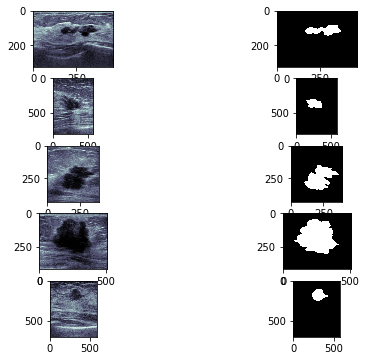

In [7]:
#Set number of images to display and the plot rows and columns
n_images = 5
n_cols = 2

#define plot shape
fig, axs = plt.subplots(n_images,n_cols, figsize=(8, 6))

#display random images
for i in range(0,n_images):
    
    #get random image and its mask
    random_img = random.randint(0,len(tumor_images)-1)
    img = tumor_images[random_img] 
    mask = mask_images[random_img]
    
    #plot imagae and mask
    axs[i,0].imshow(img,cmap=plt.cm.bone)
    axs[i,1].imshow(mask,cmap="gray")

plt.show()

### Extraer parches de una images (entrenamiento y prueba)

In [8]:
#Extract patche for model training, return the extracted patches and the class that each belong
def extractPatchesTrain(im,mask,size_patch,p = 0.01):
    
    center_patch = round(size_patch/2)
    
    #path image with zeros to extract patches from the image borders
    im2 = np.pad(im,center_patch, mode = 'constant', constant_values = 0)
    
    #Get pixels in the image pixels that belong to tumor (val = 1) and background (val = 0) 
    tumor_idx = np.where(mask != 0)
    back_idx = np.where(mask == 0)
    
    #extract number of patches to extract acoording to the percentage sert by p
    n_tumor = np.shape(tumor_idx)[1]
    n_back = np.shape(back_idx)[1]
    n_samples = round(n_tumor*p)
    
    #get random indexes to tumor and background pixels
    rand_tumor = np.random.randint(0,n_tumor,n_samples)
    rand_back = np.random.randint(0,n_back,n_samples)
    
    patches_img = []
    classes = []
    
    #Get tumor and background patches and their classes
    for pix_tumor, pix_back in zip(rand_tumor, rand_back):
        
        #Get pixel location in padded image
        #Tumor pixel
        x_tumor = tumor_idx[1][pix_tumor] + center_patch
        y_tumor = tumor_idx[0][pix_tumor] + center_patch
        
        #Background pixel
        x_back = back_idx[1][pix_back] + center_patch
        y_back = back_idx[0][pix_back] + center_patch
        
        #Get window limits to extract patch
        tumor_patch_limits = [x_tumor - center_patch, x_tumor + center_patch, y_tumor - center_patch, y_tumor + center_patch]
        back_patch_limits = [x_back - center_patch, x_back + center_patch, y_back - center_patch, y_back + center_patch]
    
        #Extract patches from padded image and class
        patches_img.append(im2[tumor_patch_limits[2]:tumor_patch_limits[3],tumor_patch_limits[0]:tumor_patch_limits[1]])
        classes.append(1)
        patches_img.append(im2[back_patch_limits[2]:back_patch_limits[3],back_patch_limits[0]:back_patch_limits[1]])
        classes.append(0)
        
    return np.array(patches_img), np.array(classes)
 
#Extract patches for Testing, do not require to get class
def extractPatchesTest(im,size_patch):
    
    center_patch = round(size_patch/2)
    
    #Pad Test image to extract patches from pixels of the image borders
    im2 = np.pad(im,center_patch, mode = 'constant', constant_values = 0)
    
    patches_img = []

    #Get patches for each pixel in the image
    for i in range(im.shape[1]):
        for j in range(im.shape[0]): 
        
            x = i + center_patch
            y = j + center_patch
            
            patch_limits = [x - center_patch, x + center_patch, y - center_patch, y + center_patch]      
            patches_img.append(im2[patch_limits[2]:patch_limits[3],patch_limits[0]:patch_limits[1]])

    return np.array(patches_img)

### Visualizar los parches

Numero de parches:
1994


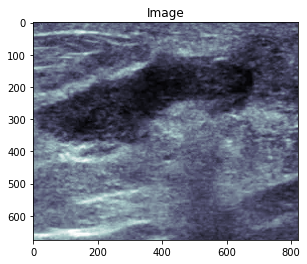

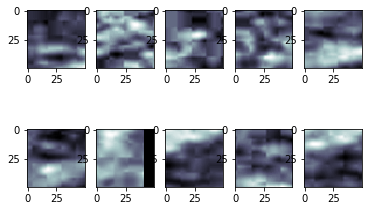

Patches claseses: 1 = Tumor; 0 = Fondo
[1, 1, 1, 1, 0, 0, 0, 1, 0, 1]


In [9]:
#Get random image
random_img = random.randint(0,len(tumor_images)-1)
img = tumor_images[random_img]
mask = mask_images[random_img]

#Extract patches from image: returns the image pathces and the class they belong
[patches_img, patches_classes] = extractPatchesTrain(img, mask, size_patch = 50 , p = 0.01)

print("Numero de parches:")
print(len(patches_img))

#Set number of patches to visualize
n_patches = 10
n_cols = 5
n_rows = math.ceil(n_patches/n_cols)

#stroe class of visualized patches
classes = []

fig = plt.figure()
plt.imshow(img,cmap=plt.cm.bone)
plt.title("Image")

#define plot shape
fig, axs = plt.subplots(n_rows,n_cols)

#Visualize patch and class
for i in range(0,n_patches):
    
    random_patch = random.randint(0,len(patches_img)-1)
    
    patch = patches_img[random_patch]
    classes.append(patches_classes[random_patch])
    
    row = i // n_cols
    col = i % n_cols
    axs[row,col].imshow(patch,cmap=plt.cm.bone)

    
plt.show()

print("Patches claseses: 1 = Tumor; 0 = Fondo")
print(classes)

### Definición del modelo

A continuación se define el modelo de Deep Learning que se va a utilizar. En esta caso se utilizara una Red Neuronal profunda llamada LeNeT. Esta es una red neuronal bastante sencilla y poco profunda, utilizada para la clasificación de imagenes. Este modelo se encargara de clasificar los parches de las imágenes en tumor o fondo.

La arquitectura LeNet consiste en dos sets de capas convolucionales y de pooling, seguidas por una capa de aplanamiento (converir un tensor multidimensional en uno de 1 dimensión), y dos capas totalmente conectadas. 

![lenet](Notebook_Imgs/lenet.png "Arquitectura LeNet")
![capas de convolución y de pooling](Notebook_Imgs/conv_pool_layer.png "Capas de convolución y pooling")


In [10]:
#Define the LeNet-5 architecture
def leNetFn(image_size, num_classes):
    
    #1 Input Layer: size of images
    #2 Conv Layer: 6 filters of size [5x5] with ReLU
    #3 Pool Layer: Stride = 2 and a 2x2 pooling
    #4 Conv Layer: 16 filters of size [5x5] with ReLU
    #5 Pool Layer: Stride = 2 and a 2x2 pooling
    #6 FC Layer: 120 neurons 
    #7 FC Layer: 84 neurons with dropout regularization rate of 0.4 
    #8 Logits Layer: a FC layer with 10 neurons, one foe each digit target class (0-9) or softmax
    
    #activation = tf.nn.sigmoid
    activation = tf.nn.relu
    
    #1 Input Layer: size of images
    if K.image_data_format() == 'channels_first':
        input_shape = (1, image_size, image_size)
    else:
        input_shape = (image_size, image_size, 1)
    
    #definition of CONV/POOL layers
    model = tf.keras.Sequential()
    
    #2 Conv Layer: 6 filters of size [5x5] with ReLU
    model.add(tf.keras.layers.Conv2D(
            filters = 6,
            kernel_size = 5,
            padding = "valid",
            strides = 1,
            activation = activation,
            input_shape = input_shape))
    
    #3 Pool Layer: Stride = 2 and a 2x2 pooling
    model.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    
    #4 Conv Layer: 16 filters of size [5x5] with ReLU
    model.add(tf.keras.layers.Conv2D(
            filters = 16,
            kernel_size = 5,
            padding = "valid",
            strides = 1,
            activation = activation))
    
    #5 Pool Layer: Stride = 2 and a 2x2 pooling
    model.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    
    #Definition of FC layers
    model.add(tf.keras.layers.Flatten())
    
    #6 FC Layer: 120 neurons 
    model.add(tf.keras.layers.Dense(
            units = 120, 
            activation = activation))
    #7 FC Layer: 84 neurons with dropout regularization rate of 0.4 
    model.add(tf.keras.layers.Dense(
            units = 84, 
            activation = activation))
    #model.add(tf.keras.layers.Dropout(rate = 0.4))  #If training drop out a random percent of the activations
    
    #8 Logits Layer: a FC layer with 10 neurons, one for each class (0 = background || 1 = tumor) or softmax
    model.add(tf.keras.layers.Dense(
            units = num_classes, 
            activation = tf.nn.softmax))
    
    return model

### Compilación y entrenamiento del modelo

La compilación del modelo se refiere a la definición de los métodos que utilizara el modelo para optimizar los pesos de la red, en este caso se debe de definir:

- Función objetivo (loss function)
- Algoritmo de optimización

Por otro lado para el entrenamiento se deben de deinir:

- Número de épocas (numero de iteraciones en las que se llevara acabo el entrenamiento)
- Tamaño del batch 
![batch](Notebook_Imgs/batch_training.jpg "Entrenamiento por batches")
- Tasa de aprendizaje (Learning Rate, controla que tanto cambia el model en respuesta ala función de perdida.
![tasa de aprendizaje](Notebook_Imgs/learning_rate.gif "Tasa de aprendizaje")


### Definir parametros de compilación

In [11]:
#Define loss evaluation for the mode, Our own evalutation loss functioncs can be implemented
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

#Define the model compile options
def compile_LeNet_Model(model):
    
    #Choose the type of tryning algorithm to optimize weights
    #optimizer =  tf.keras.optimizers.RMSprop(lr = 0.01)
    optimizer = "adam"
    
    #Choos the loss function to used to optimize weights
    #loss = root_mean_squared_error
    loss = "categorical_crossentropy"
    
    #Choose metrics to compute loss function
    metrics = ["accuracy", "TruePositives", "FalsePositives"]
    
    #Set compiliation parameters to the model
    model.compile(   
        optimizer = optimizer,
        loss = loss,
        metrics = metrics)

    return model

### Definir parámetros de entrenamiento

In [12]:
#Train the defined model
def train_LeNet_Model(train_images,train_masks,model,image_size):
    
    #Extract patch data from training images
    data = np.zeros((1,28,28))
    classes = []
    
    for i in range(np.size(train_images)):
        [patches_img, labels] = extractPatchesTrain(train_images[i], train_masks[i], image_size)
        data = np.concatenate((data,patches_img),axis=0)
        classes = np.concatenate((classes,labels))

    #Formating data into nedded model shapes
    data = np.delete(data,0,axis=0)
    
    if K.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, image_size, image_size)
    else:
        data = data.reshape(data.shape[0], image_size, image_size, 1)
    
    # convert class vectors to binary class matrices
    classes = tf.keras.utils.to_categorical(classes, num_classes)
    
    #Shuffle data for model training
    shuffled_indices = np.arange(data.shape[0])
    np.random.shuffle(shuffled_indices)
    shuffled_data = data[shuffled_indices]
    shuffled_classes = classes[shuffled_indices]
    
    #Split data in train and validation sets [90,10]
    samples_count = shuffled_data.shape[0]
    train_samples_count = int(0.9 * samples_count)
    validation_samples_count = int(0.1 * samples_count)

    train_data = shuffled_data[:train_samples_count]
    train_classes = shuffled_classes[:train_samples_count]
    validation_data = shuffled_data[train_samples_count:train_samples_count+validation_samples_count]
    validation_classes = shuffled_classes[train_samples_count:train_samples_count+validation_samples_count]

    #defining training paramenters
    #Number of evaluation images used in each batch
    batch_size = round(train_data.shape[0]*0.1)
    
    #Number of epochs to train
    epochs = 5
    
    #Stop when the loss grows instead of diminish
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=5) #To check overfitting
    
    #Train the model
    model.fit(train_data,train_classes,
                         batch_size = batch_size,
                         epochs = epochs,
                         callbacks=[early_stopping],
                         validation_data = (validation_data,validation_classes),
                         verbose = 1)
    
    return model

### Entrenar modelo
Para entrenar el modelo se deben de definir los datos de entrenamiento y de prueba que se utilizaran: 
En este caso se utiliza:

- Entrenamiento 90%
- Prueba 10%

In [13]:
#Split data in train and test sets [90,10]
samples_count = len(tumor_images)
print("Total number of images")
print(samples_count)

#Number of samples for each set
train_samples_count = int(0.9 * samples_count)
test_samples_count = int(0.1 * samples_count)

#extract data 
train_images = tumor_images[:train_samples_count]
train_masks = mask_images[:train_samples_count]
test_images = tumor_images[train_samples_count:train_samples_count+test_samples_count]
test_masks = mask_images[train_samples_count:train_samples_count+test_samples_count]

print("Number of training images")
print(len(train_images))
print("Number of test images")
print(len(test_images))

#Define paramenters: Number of clases (tumor-background), size of square patches
num_classes = 2
image_size = 28

#Create model
model = leNetFn(image_size, num_classes)

#compile model
model = compile_LeNet_Model(model)

#train model
model = train_LeNet_Model(train_images,train_masks,model,image_size)

print("Saving wieghts")
model.save_weights("LeNet_tumor.h5")

Total number of images
58
Number of training images
52
Number of test images
5
Train on 71357 samples, validate on 7928 samples
Epoch 1/5
71357/71357 [==============================] - 20s 277us/sample - loss: 0.6341 - accuracy: 0.5452 - TruePositives: 38904.0000 - FalsePositives: 32453.0000 - val_loss: 0.6090 - val_accuracy: 0.6028 - val_TruePositives: 4779.0000 - val_FalsePositives: 3149.0000
Epoch 2/5
71357/71357 [==============================] - 18s 248us/sample - loss: 0.5716 - accuracy: 0.7087 - TruePositives: 50572.0000 - FalsePositives: 20785.0000 - val_loss: 0.5220 - val_accuracy: 0.7904 - val_TruePositives: 6266.0000 - val_FalsePositives: 1662.0000
Epoch 3/5
71357/71357 [==============================] - 18s 247us/sample - loss: 0.4893 - accuracy: 0.7883 - TruePositives: 56248.0000 - FalsePositives: 15109.0000 - val_loss: 0.4803 - val_accuracy: 0.7899 - val_TruePositives: 6262.0000 - val_FalsePositives: 1666.0000
Epoch 4/5
71357/71357 [==============================] - 17s 2

### Segmentar una nueva imagen
Para segmentar una nueva imagen, se deben de extraer parches alrededor de todos los pixeles de la imagen y clasificarlos como tumor o fondo. El modelo entrega la probabilidad de cada pixel a pertencer al tumor o el fondo, de acuerdo a su vecindad. Estos datos, juntos con la información de la localización del pixel se utilizan para reconstruir dos imágenes:

- Imagen de probabilidad, mostrando la probabilidad de los pixeles de pertencer al tumor
- Imagen de clasificación, que muestra cual es la clase que tiene más probabilidad de ser el pixel



In [14]:
def predictClassModel(image,size_patch,model):

    data = extractPatchesTest(image,size_patch)
    
    if K.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, image_size, image_size)
    else:
        data = data.reshape(data.shape[0], image_size, image_size, 1)
        
    predictions = model.predict(data)
    
    tumor_prob = predictions[:,1]
    classes = predictions.argmax(axis=-1)
    
    prob_image = tumor_prob.reshape(image.shape,order = 'F')
    class_image = classes.reshape(image.shape,order = 'F')

    return prob_image, class_image

### Probar una imagen del conjunto de prueba

1


Text(0.5, 1.0, 'Class image')

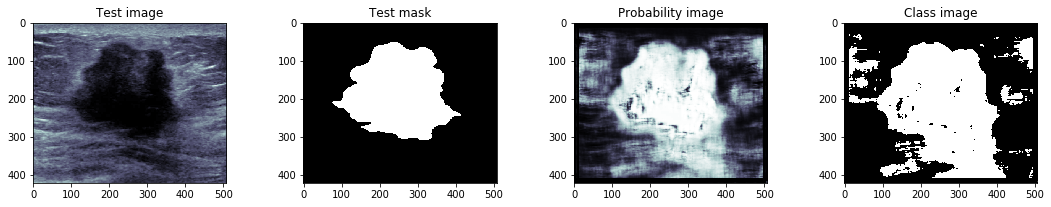

In [24]:
#Get random image and its mask from test data set
test_idx = random.randint(0,len(test_images)-1)
print(test_idx)
test_image = test_images[test_idx]
test_mask = test_masks[test_idx]

#Load saved weights (more epochs)
model.load_weights("LeNet_tumor_60.h5")

#Predict the probability of each pixel
[prob_image, class_image] = predictClassModel(test_image,image_size,model)
    
#Display test image and the results
fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 4, 1)
ax.imshow(test_image, cmap=plt.cm.bone)
ax.set_title("Test image")

ax = fig.add_subplot(1, 4, 2)
ax.imshow(test_mask, cmap="gray")
ax.set_title("Test mask")

ax = fig.add_subplot(1, 4, 3)
ax.imshow(prob_image, cmap=plt.cm.bone)
ax.set_title("Probability image")

ax = fig.add_subplot(1, 4, 4)
ax.imshow(class_image, cmap="gray")
ax.set_title("Class image")
    

### Post-procesamiento
Debido a la complejidad del problema el método de segmentación presenta errores. Para esto es necesario limpiar la imagen y elegir la región con mayor probabilidad de ser tumor.

- Se utiliza un método de apertura para suavizar las formas y eliminar regiones muy pequeñas para ser tumor

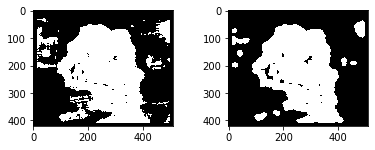

In [25]:
#Structure for opening
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))

#Opening image t clean it and soften the shapes
opening = cv2.morphologyEx(class_image.astype(np.uint8), cv2.MORPH_OPEN, kernel)

#Display original class image and opening
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(class_image, cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(opening, cmap="gray")

### Visualización de resultados

Se obtienen los objetos marcados como posibles tumores por el método de segmentación. Estos deben de ser procesados para conocer la probabilidad de cada uno de ellos para ser tumor

Number of possible tumor regions
11
420


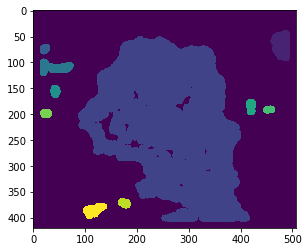

In [26]:
#Obtain list of all objects found in the binary image
n_objs, labels = cv2.connectedComponents(opening)

print("Number of possible tumor regions")
print(n_objs)
print(len(labels))

plt.imshow(labels)

In [27]:
#Objects binary image, probability and bounding box
obj_imgs = []
probs = []
boxes = []

for label in range(0,n_objs):
    
    #Get pixels that belong to the object
    obj_idx = np.where(labels == label)

    #Construct binary image wiht only the object mask
    obj_img = np.zeros(test_image.shape)
    obj_img[obj_idx] = 1
    obj_imgs.append(obj_img)
    
    #Get probability of the object using the computed probability image
    obj_prob = prob_image[obj_idx]
    probs.append(np.mean(obj_prob))
    
    #Get bounding box using object mask
    x1 = np.min(obj_idx[1])
    y1 = np.min(obj_idx[0])
    x2 = np.max(obj_idx[1])
    y2 = np.max(obj_idx[0])
    boxes.append([x1, y1, x2, y2])

plt.show()
print(probs)

[0.20620348, 0.74610364, 0.87187624, 0.6656794, 0.68159485, 0.6436243, 0.6597037, 0.58574367, 0.6423661, 0.6361476, 0.6694502]


In [28]:
#function to generate random colors for class display
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [29]:
#Function to apply a mask to each object in the image
def apply_mask(image, mask, color, alpha=0.2):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1.0,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c]*255,
                                  image[:, :, c])
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


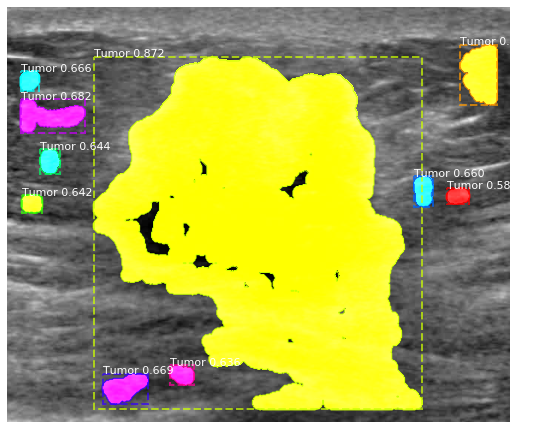

In [30]:
#Visualize objects
fig, ax = plt.subplots(1,figsize = (9,8))

ax.axis('off')

# Generate random colors
colors = random_colors(n_objs-1)

#Transform test_image to RGB color (to display objects in different colors)
masked_img = cv2.cvtColor(test_image.astype(np.float32),cv2.COLOR_GRAY2RGB)
for i in range(1, n_objs):

    #Get new color for object
    color = colors[i-1]

    #Show bounding box of the object in the image
    box = boxes[i]
    p = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],linewidth=2,
                                    alpha=0.7, linestyle="dashed",
                                    edgecolor=color, facecolor='none')
    ax.add_patch(p)

    #Show propability of the object in the image
    class_id = 1
    score = probs[i]
    label = "Tumor"
    caption = "{} {:.3f}".format(label, score) 
    ax.text(box[0], box[1], caption,
            color='w', size=11, backgroundcolor="none")

    mask_img = obj_imgs[i] 
    masked_img = apply_mask(masked_img, mask_img, color)

    #Show mask of the object in the image
    # Pad to ensure proper polygons for masks that touch image edges.
    padded_mask = np.zeros(
        (mask_img.shape[0] + 2, mask_img.shape[1] + 2), dtype=np.float32)
    padded_mask[1:-1, 1:-1] = mask_img
    contours = find_contours(padded_mask, 0.5)
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        p = Polygon(verts, facecolor="none", edgecolor=color)
        ax.add_patch(p)

#show results
ax.imshow(masked_img.astype(np.float32))
plt.show()